<a href="https://colab.research.google.com/github/tirth5828/Age-Detection-DL/blob/main/DL_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import tensorflow as tf

import keras
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split

from keras import metrics

from keras.models import model_from_json
import matplotlib.pyplot as plt

import os
from os.path import join
from google.colab import drive

import cv2

import gc

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
dataset_directory = '/content/drive/My Drive/data'

image_size = 100
classes = 101

# #age groups
# age_ranges = {
#     (6,20) : 0, 
#     (35,40) : 1, 
#     (55,98) : 2
# }

#age groups
age_ranges = {
    (0,27) : 0, 
    (28,47) : 1, 
    (48,100) : 2
}

# convert age to age group
def convert_ranges(age):
  for key in age_ranges:
    if key[0] <= age <= key[1]:
      return age_ranges[key]

# transform labels to age
def transform_labels_age(labels_vec):
  new_labels_vec = []
  for x in labels_vec:
    x2 = x.split('-')
    new_labels_vec.append(convert_ranges(int(x2[1])))
  return np.array(new_labels_vec)

# transform labels to index
def transform_labels_index(labels_vec):
  new_labels_vec = []
  for x in labels_vec:
    x2 = x.split('-')
    new_labels_vec.append(convert_ranges(int(x2[0])))
  return np.array(new_labels_vec)

In [4]:
# load train dataset
# set of data to be used for learning
images_train = np.load(join(dataset_directory, 'train_images.npy'))
print(images_train.shape)

# load train dataset labels
labels_train_full = np.load(join(dataset_directory, 'train_labels.npy'))

# transform trains dataset labels....................................................................................
labels_train = transform_labels_age(labels_train_full)

# load valid dataset
# set of data to be used to provide an unbiased evaluation of the model fitted on the the training dataset while tuning model hyperparameters
images_val = np.load(join(dataset_directory, 'val_images.npy'))

# load valid dataset labels
labels_val_full = np.load(join(dataset_directory, 'val_labels.npy'))

# transmiform valid dataset labels....................................................................................
labels_val = transform_labels_age(labels_val_full)

# load test dataset(public)
# set of data to be used to provide an unbiased evaluation of the final model fitted on the training dataset
images_test_public = np.load(join(dataset_directory, 'test_images.npy'))

# reshape datasets (normalisation)
images_train = images_train.reshape([-1, image_size, image_size, 3]) / 255.0
images_val = images_val.reshape([-1, image_size, image_size, 3]) / 255.0
images_test_public = images_test_public.reshape([-1, image_size, image_size, 3]) / 255.0



(13475, 100, 100, 3)


In [ ]:
index_val = transform_labels_index(labels_val_full)

In [5]:
print(images_train.shape)
print(images_val.shape)
print(images_test_public.shape)

print(labels_train_full[:9])
print(labels_train[:9])

print(labels_val_full[:9])
print(labels_val[:9])

(13475, 100, 100, 3)
(2595, 100, 100, 3)
(2374, 100, 100, 3)
['12466-81' '12466-61' '12466-81' '12466-61' '12566-35' '12566-37'
 '12566-35' '12566-35' '12566-37']
[2 2 2 2 1 1 1 1 1]
['12626-16' '12726-37' '12726-37' '12726-37' '12726-37' '12726-37'
 '12726-37' '12726-39' '12726-37']
[0 1 1 1 1 1 1 1 1]


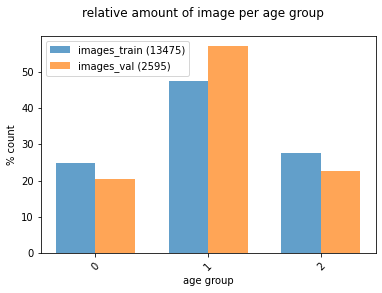

In [ ]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('age group')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of image per age group')
plot_bar(labels_train, loc='left')
plot_bar(labels_val, loc='right')
plt.legend([
    'images_train ({0})'.format(len(labels_train)), 
    'images_val ({0})'.format(len(labels_val))
]);

In [6]:
#VGG-Face model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [7]:
weights = "/content/drive/MyDrive/vgg_face_weights.h5"

In [8]:
model.load_weights(weights)

In [9]:
for layer in model.layers[:-7]:
    layer.trainable = False

base_model_output = Sequential()
base_model_output = Convolution2D(classes, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)

age_model = Model(inputs=model.input, outputs=base_model_output)

In [ ]:
if True:
    for layer in model.layers:
        print(layer, layer.trainable)
    
    print("------------------------")
    for layer in age_model.layers:
        print(layer, layer.trainable)

In [10]:
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

age_model.compile(loss='categorical_crossentropy'
                  , optimizer=keras.optimizers.Adam()
                  #, optimizer = sgd
                  , metrics=['accuracy']
                 )

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [11]:
checkpointer = ModelCheckpoint(
    filepath='classification_age_model.hdf5'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'auto'
)

In [12]:
scores = []

In [13]:
enableFit = False

if enableFit:
    epochs = 250
    batch_size = 256

    for i in range(epochs):
        print("epoch ",i)
        
        ix_train = np.random.choice(images_train.shape[0], size=batch_size)


        
        score = age_model.fit(
            images_train[ix_train], images_val[ix_train]
            , epochs=1
            , validation_data=(labels_train, labels_val)
            , callbacks=[checkpointer]
        )
        
        scores.append(score)
    
    #restore the best weights
    from keras.models import load_model
    age_model = load_model("classification_age_model.hdf5")
    
    age_model.save_weights('age_model_weights.h5')
        
else:
    #pre-trained weights for age prediction: https://drive.google.com/file/d/1YCox_4kJ-BYeXq27uUbasu--yz28zUMV/view?usp=sharing
    age_model.load_weights("/content/drive/MyDrive/age_model_weights.h5")

In [ ]:
val_loss_change = []; loss_change = []
for i in range(0, len(scores)):
    val_loss_change.append(scores[i].history['val_loss'])
    loss_change.append(scores[i].history['loss'])

plt.plot(val_loss_change, label='val_loss')
plt.plot(loss_change, label='train_loss')
plt.legend(loc='upper right')
plt.show()

In [14]:
def get_label(predection):
  output = []
  for i in predection:
    max = -1
    max_id = -1
    for i,val in enumerate(i): 
      if val>max:
        max = val
        max_id = i
    output.append(convert_ranges(max_id + 1))
  return output


In [15]:
output_labels = []

In [16]:
resize_images_test_public = []

threshold = 50

for i,image in enumerate(images_test_public):
  if (i%threshold == 0 or i == len(images_test_public) - 1) and (i!=0):
    resize_images_test_public = np.array(resize_images_test_public[:])
    predictions = age_model.predict(resize_images_test_public)
    output_labels.extend(get_label(predictions))
    resize_images_test_public = []
  resize_images_test_public.append(cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC))

1/1 [==============================] - 12s 12s/step


In [17]:
import pandas as pd 
import os
from datetime import datetime

df = pd.DataFrame(output_labels)
df.index.name='ID'
os.chdir('/content/drive/My Drive/results')

currentDateTime = datetime.now().strftime("%d%m%Y_%H%M%S")

#df.to_csv(f'45892342-conv-{currentDateTime}.csv', header=['Prediction'])
df.to_csv(f'45892342-nconv-CNN.csv', header=['Prediction'])